This notebook reproduces Bernoulli experiment results in our paper, 

https://arxiv.org/pdf/1810.04777.pdf

Specifically, it displays the variances gains of Rao-Blackwellization shown in Figure 2. 

See bernoulli_optimization_experiments.ipynb for the experiments on the optimization (Figure 1). 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn
import torch.optim as optim 

from copy import deepcopy

import bernoulli_experiments_lib as bern_lib

import sys
sys.path.insert(0, '../../rb_utils/')
import optimization_lib as optim_lib
import baselines_lib as bs_lib

In [2]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [3]:
np.random.seed(454)
_ = torch.manual_seed(454)

In [4]:
# fixed parameters
d = 3
# p0 = torch.rand(d)
p0 = torch.Tensor([0.6, 0.51, 0.48])
print('p0: ', p0, '\n')

print('sum(p0^2): ', torch.sum(p0**2))
print('sum((1 - p0)^2): ', torch.sum((1 - p0)**2), '\n')

# the optima
x_optimal = torch.argmin(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

optimal_loss = torch.min(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

print('optimal loss: ', optimal_loss)
print('optimal x: ', x_optimal.numpy())

p0:  tensor([0.6000, 0.5100, 0.4800]) 

sum(p0^2):  tensor(0.8505)
sum((1 - p0)^2):  tensor(0.6705) 

optimal loss:  tensor(0.6705)
optimal x:  1


In [5]:
# random init for phi
phi0 = torch.Tensor([0.0])
phi0.requires_grad_(True)
print('init phi0: ', phi0)
print('init e_b: ', sigmoid(phi0))

init phi0:  tensor([0.], requires_grad=True)
init e_b:  tensor([0.5000], grad_fn=<SigmoidBackward>)


In [6]:
params = [phi0]
optimizer = optim.SGD(params, lr = 1.0)

# True gradient

In [7]:
bern_experiment = bern_lib.BernoulliExperiments(p0, d, phi0)

In [8]:
bern_experiment.set_var_params(deepcopy(phi0))

In [9]:
optimizer.zero_grad()

In [10]:
loss = bern_experiment.get_full_loss()

In [11]:
loss.backward()

In [12]:
true_grad = deepcopy(bern_experiment.var_params['phi'].grad)
print(true_grad)

tensor([-0.0450])


# analytically integrate REINFORCE gradient: should recover the true gradient

In [13]:
bern_experiment.set_var_params(deepcopy(phi0))
optimizer.zero_grad()
ps_loss = bern_experiment.get_pm_loss(topk = 8, grad_estimator = bs_lib.reinforce)

In [14]:
ps_loss.backward()
reinforce_analytic_grad = deepcopy(bern_experiment.var_params['phi'].grad)
print(reinforce_analytic_grad)

tensor([-0.0450])


In [15]:
assert reinforce_analytic_grad == true_grad

# Reinforce + CV gradient

In [16]:
n_samples = 10000
reinforce_grads = bern_lib.sample_bern_gradient(phi0, bern_experiment, 
                                  topk = 0, 
                                  grad_estimator = bs_lib.reinforce,
                                  n_samples = n_samples)

In [17]:
print('true_grad: ', true_grad.numpy())
print('mean reinforce grad: ', torch.mean(reinforce_grads).numpy())
print('variance: ', torch.var(reinforce_grads).numpy())

print('scaled error: ', (torch.std(reinforce_grads) / np.sqrt(n_samples) * 3).numpy())

true_grad:  [-0.04500002]
mean reinforce grad:  -0.056248475
variance:  0.443401
scaled error:  0.01997651


Text(0.5, 0, 'reinforce gradients')

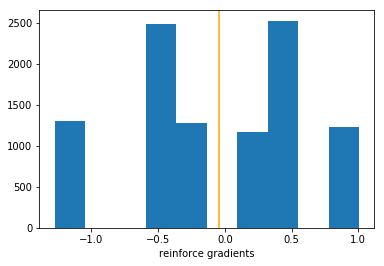

In [18]:
plt.hist(reinforce_grads)
plt.axvline(x=true_grad, color = 'orange') # true gradient 

plt.xlabel('reinforce gradients')

# Rao-Blackwellize

Here we examine the variance of REINFORCE after using our Rao-Blackwellization procedure. We display the variance as a function of $k$, the number of categories summed.  

In [19]:
print(phi0)

tensor([0.], requires_grad=True)


In [ ]:
n_samples = 10000

mixed_grads_array = torch.zeros((2**d + 1, n_samples))

for i in range(0, 2**d + 1): 
    print(phi0)
    grads = bern_lib.sample_bern_gradient(phi0, bern_experiment, 
                                topk = i, 
                                grad_estimator = bs_lib.reinforce_w_double_sample_baseline,
                                n_samples = n_samples)
    
    mixed_grads_array[i, :] = grads
    
    print('topk = {}'.format(i))
    print('mean reinforce grad: ', torch.mean(grads).numpy())
    print('variance: ', torch.var(grads).numpy())


tensor([0.], requires_grad=True)
topk = 0
mean reinforce grad:  -0.045077994
variance:  0.012753774
tensor([0.], requires_grad=True)
topk = 1
mean reinforce grad:  -0.045844004
variance:  0.007630086
tensor([0.], requires_grad=True)
topk = 2
mean reinforce grad:  -0.04464275
variance:  0.0063941707
tensor([0.], requires_grad=True)
topk = 3
mean reinforce grad:  -0.04470663
variance:  0.005205873
tensor([0.], requires_grad=True)
topk = 4
mean reinforce grad:  -0.044553503
variance:  0.0036560483
tensor([0.], requires_grad=True)


In [ ]:
# Lets look at the histogram of the distribution of 
# the gradient estimates

for i in range(1, 2**d): 
    plt.figure()
    plt.hist(mixed_grads_array[i-1, :])
    plt.axvline(x=true_grad, color = 'orange') # true gradient 
    
    plt.title('num_reinforced = {}'.format(i))
    plt.xlabel('gradients')

In [ ]:
fontsize = 16

In [ ]:
# summarize distribution all on the same plot
# Error bars are 3 * st. error of the distribution 

mixed_grads_means = np.mean(mixed_grads_array.numpy(), axis = 1)
mixed_grads_stds = np.std(mixed_grads_array.numpy(), axis = 1)

plt.boxplot(mixed_grads_array, positions = range(2**d + 1))

plt.plot(np.linspace(0, 2**d), true_grad.numpy() * np.ones(50), '--')

plt.ylabel('Gradient estimates', fontsize = fontsize)
plt.xlabel('Categories summed', fontsize = fontsize)
plt.title('Gradient estimates at $\eta$ = {}'.format(0), fontsize = fontsize)

plt.tight_layout()

# plt.savefig('../icml_figures/bernoulli_variances_reinforce_eta0')

In [ ]:
plt.plot(np.arange(0, 2**d + 1), mixed_grads_stds, 'x-', markersize = 12)
plt.xlabel('Number summed')
plt.ylabel('st. dev. of gradient')
plt.title('standard errors at $\eta$ = {}'.format(phi0.detach().numpy()[0]))

# The variance reduction of Rao-Blackwellization is more pronounced as the variational distribution becomes more concentrated

Let $\phi$ be equal to -4, so the b is heavily concentrated on (0, 0, 0). 

In [ ]:
phi0 = torch.Tensor([-4.0])
phi0.requires_grad_(True)

In [ ]:
bern_experiment.set_var_params(deepcopy(phi0))
class_weights = torch.exp(bern_experiment.get_log_q())
print(class_weights)

In [ ]:
# again assert that analyitcally summing REINFORCE returns the true gradient

In [ ]:
optimizer.zero_grad()
loss = bern_experiment.get_full_loss()
loss.backward()


true_grad = deepcopy(bern_experiment.var_params['phi'].grad)
print(true_grad)

In [ ]:
bern_experiment.set_var_params(deepcopy(phi0))
optimizer.zero_grad()
ps_loss = bern_experiment.get_pm_loss(topk = 8, grad_estimator = bs_lib.reinforce)

ps_loss.backward()
reinforce_analytic_grad = deepcopy(bern_experiment.var_params['phi'].grad)
print(reinforce_analytic_grad)

In [ ]:
assert reinforce_analytic_grad == true_grad

### re-examine the effect of rao-blackwellization at this new phi

In [ ]:
print(phi0)

In [ ]:
n_samples = 10000

mixed_grads_array2 = torch.zeros((2**d + 1, n_samples))

for i in range(0, 2**d + 1): 
    grads = bern_lib.sample_bern_gradient(phi0, bern_experiment, 
                                  topk = i, 
                                grad_estimator = bs_lib.reinforce_w_double_sample_baseline,
                                  n_samples = n_samples)
    
    mixed_grads_array2[i, :] = grads
    
    print('topk = {}'.format(i))
    print('mean reinforce grad: ', torch.mean(grads).numpy())
    print('variance: ', torch.var(grads).numpy())


In [ ]:
# Lets look at the histogram of the distribution of 
# the gradient estimates

for i in range(1, 2**d): 
    plt.figure()
    plt.hist(mixed_grads_array2[i-1, :])
    plt.axvline(x=true_grad, color = 'orange') # true gradient 
    
    plt.title('num_reinforced = {}'.format(i))
    plt.xlabel('gradients')

This is figure 2 (bottom) in our paper

In [ ]:
# summarize distribution all on the same plot
# Error bars are 3 * st. dev of the distribution 

mixed_grads_means = np.mean(mixed_grads_array2.numpy(), axis = 1)
mixed_grads_stds = np.std(mixed_grads_array2.numpy(), axis = 1)

plt.boxplot(mixed_grads_array2, positions = range(0, 2**d + 1))

plt.plot(np.linspace(1, 2**d + 1), true_grad.numpy() * np.ones(50), '--')

plt.ylabel('Gradient estimate', fontsize = fontsize)
plt.xlabel('Categories summed', fontsize = fontsize)
plt.title('Gradient estimates at $\eta$ = {}'.format(phi0.detach().numpy()[0]), 
          fontsize = fontsize)

plt.tight_layout()
# plt.savefig('../icml_figures/bernoulli_variances_reinforce_eta_neg4')

In [ ]:
plt.plot(np.arange(0, 2**d + 1), mixed_grads_stds, 'x-', markersize = 12)
plt.xlabel('Number summed')
plt.ylabel('st. error of gradient')
plt.xlabel('Number summed')
plt.ylabel('st. error of gradient')
plt.title('standard errors at $\eta$ = {}'.format(phi0.detach().numpy()[0]))